In [1]:
from IPython.display import HTML

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython.display import clear_output

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

dfTrain = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col = 'id')
dfTest = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col = 'id')
dfSubmission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

In [2]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

In [3]:
numCols = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Insurance Duration', 'Vehicle Age', 'Credit Score']
catCols = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
target = 'Premium Amount'

In [4]:
def plotMissingValues(df, title):
    missingRatio = df.isnull().sum() / len(df) * 100
    missingDf = pd.DataFrame({'column': missingRatio.index, 'missingRatio': missingRatio.values})
    
    plt.figure(figsize=(15, 6))
    plt.grid(True)
    ax = sns.barplot(x='column', y='missingRatio', data=missingDf, color="red")

    # Formating stuff
    plt.xticks(rotation=45, ha='right', fontsize = 14)
    plt.xlabel('') 
    plt.title(title, fontsize = 20)
    plt.yticks(range(0, 40, 5), fontsize = 14)
    plt.ylabel('Missing Values ratio(%)', fontsize = 12)
    
    plt.tight_layout()
    plt.show()

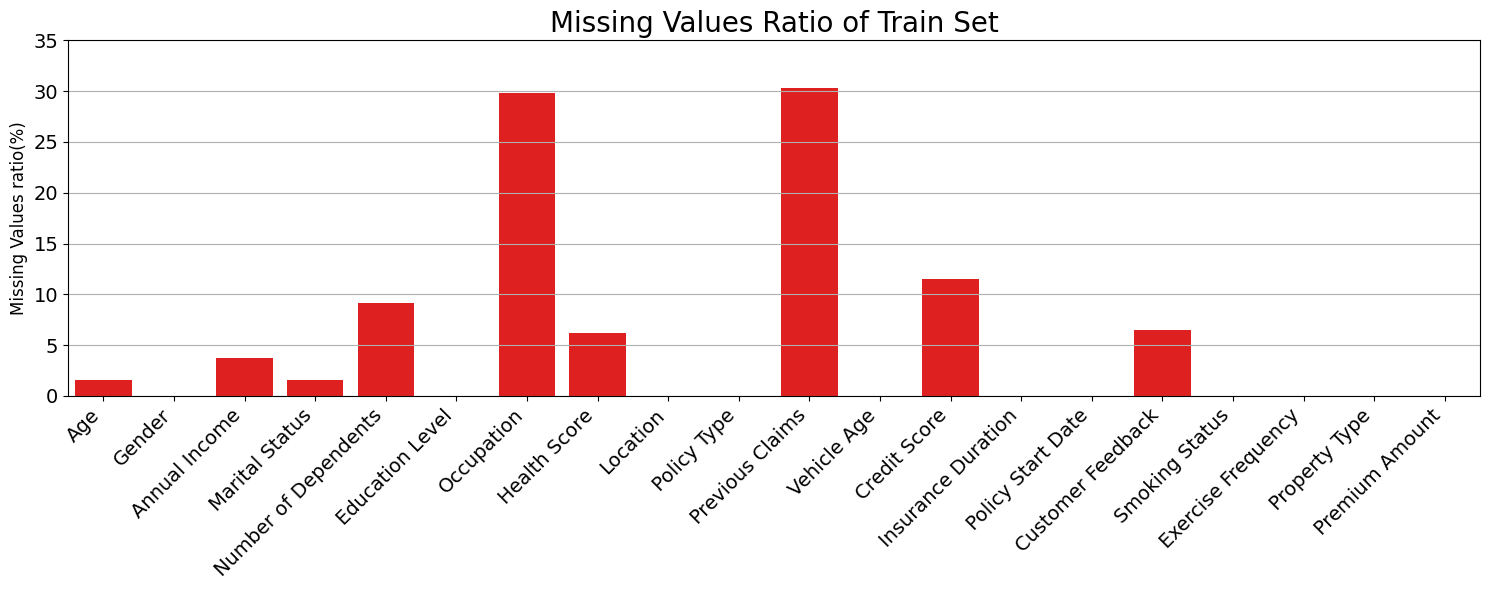

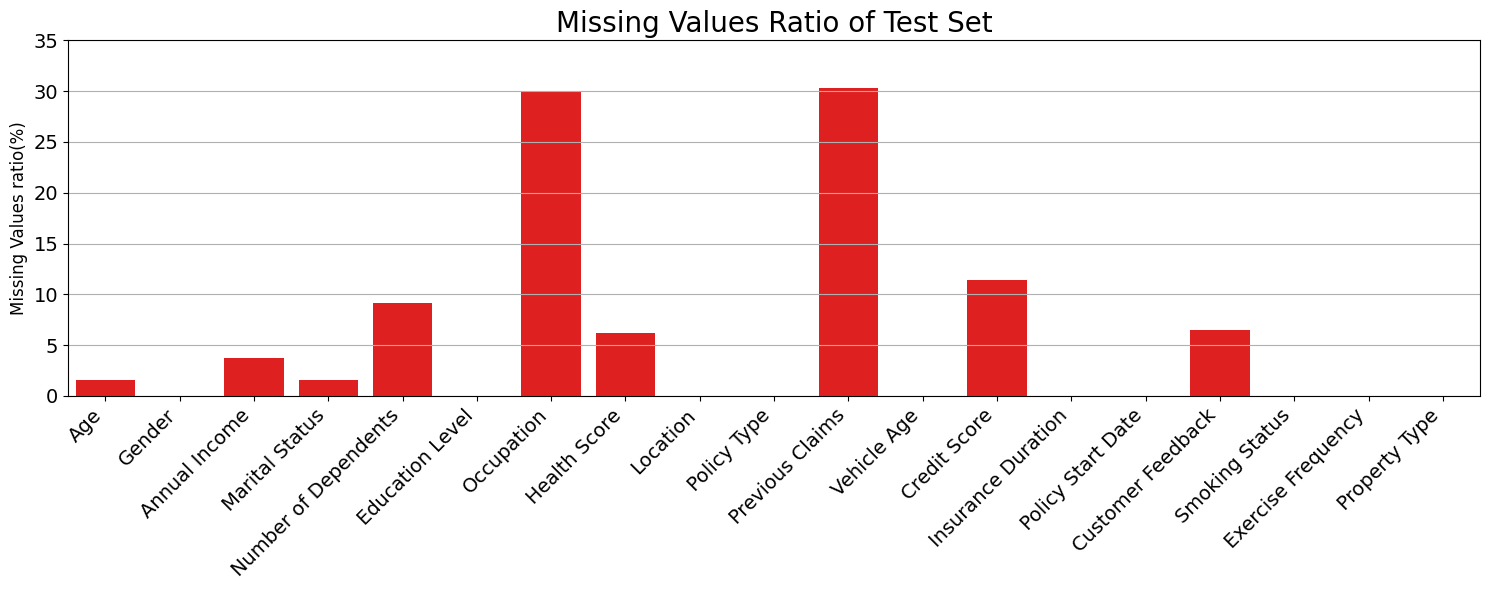

In [5]:
plotMissingValues(dfTrain, 'Missing Values Ratio of Train Set')
plotMissingValues(dfTest, 'Missing Values Ratio of Test Set')

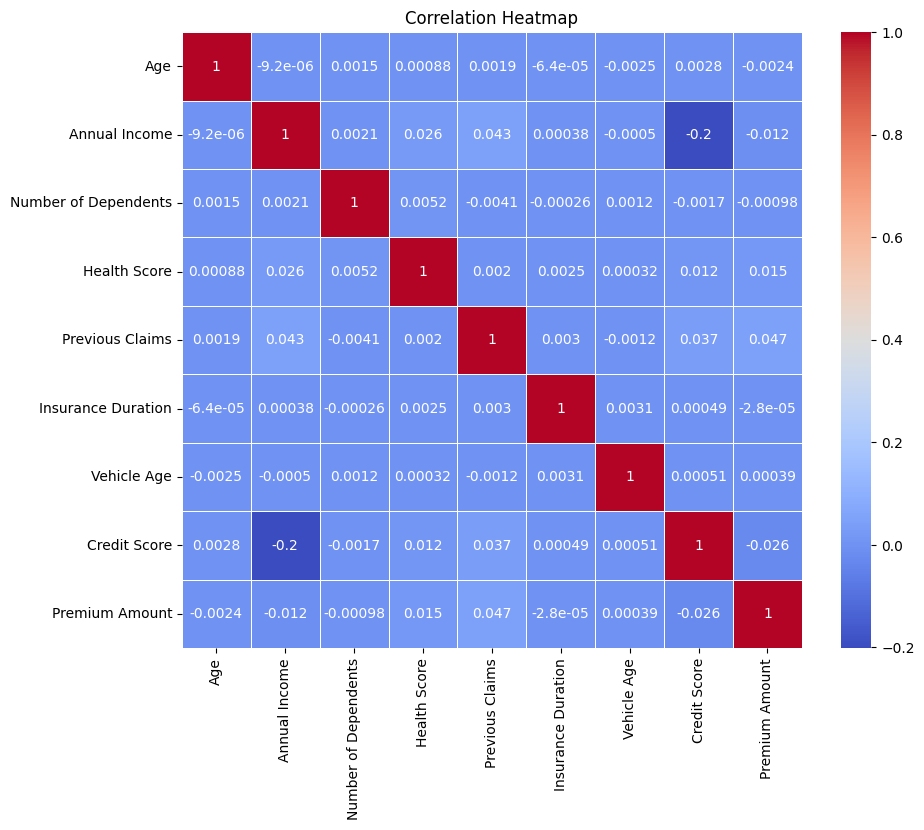

In [6]:
dfNum = dfTrain[numCols]
dfTarget = pd.DataFrame(dfTrain[target])
dfCorr = pd.concat([dfNum, dfTarget], axis=1)

corr = dfCorr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [7]:
'''
dfCat = dfTrain[catCols]
dfBar = pd.concat([dfCat, dfTarget], axis=1)

for col in catCols:
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(data=dfBar, x=col, y='Premium Amount', estimator='mean')
    plt.title(f'Barchart of target by {col}')
    plt.show()
'''

"\ndfCat = dfTrain[catCols]\ndfBar = pd.concat([dfCat, dfTarget], axis=1)\n\nfor col in catCols:\n    plt.figure(figsize=(10, 7))\n    ax = sns.barplot(data=dfBar, x=col, y='Premium Amount', estimator='mean')\n    plt.title(f'Barchart of target by {col}')\n    plt.show()\n"

In [8]:
def skewness(df):
    for c in df.columns:
        print("{} : {:.3f}".format(c, df[c].skew()))

#skewness(dfNum)

In [9]:
def preprocess(df):
    if 'Policy Start Date' in df.columns: df['Policy Start Year'] = pd.to_datetime(df.pop('Policy Start Date')).dt.year

    # get numercial and categorical columns
    numColumns = [col for col in df.select_dtypes(include=["number"]).columns if col != "Premium Amount"]
    catColumns = df.select_dtypes(exclude=["number"]).columns

    # populate missing values with mode if skewed, else with mean
    for c in numColumns:
        populate = df[c].mode()[0] if df[c].skew() > 0.5 or df[c].skew() < -0.5 else df[c].mean()
        df[c].fillna(populate, inplace=True)

    # fill missing categorical data with 'missing'
    for c in catColumns:
        df[c].fillna("missing", inplace=True)

    # transform skewed data to normalize
    for c in numColumns:
        if df[c].skew() >= 1: df[c] = np.log1p(df[c])
        elif df[c].skew() <= -1: df[c] = np.sqrt(df[c])

    # one-hot encode catColumns
    for c in catColumns:
        if c in df.columns: df = pd.get_dummies(df, columns=[c], drop_first=True)  

    return df

In [10]:
def numDist(df, column, label):
    plt.figure(figsize=(15, 6))  

    sns.set_style('whitegrid') 

    plt.subplot(1, 2, 1)
    sns.histplot(df[column], color='steelblue', kde=True, bins=100, linewidth=3)
    plt.title(f'Histogram of {label}')
    plt.xlabel(f'{label}')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.violinplot(y=df[column], color='lightsteelblue')
    plt.title(f'Violin Plot of {label}')
    plt.ylabel(label)

    plt.tight_layout() 
    plt.show()

'''
for col in numCols:
    numDist(dfTrain, column=col, label=col)
'''

'\nfor col in numCols:\n    numDist(dfTrain, column=col, label=col)\n'

In [11]:
dfTrain = preprocess(dfTrain)
dfTest = preprocess(dfTest)

In [12]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [13]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the target column and separate features and target
X = dfTrain.drop(columns=[target])
y = np.log1p(dfTrain[target])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42
    }
    
    # Initialize and train the model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        early_stopping_rounds=50,
        verbose=False
    )
    
    # Make predictions
    preds = model.predict(X_val)
    
    # Calculate RMSE
    return rmse(y_val, preds)
    

# Create the study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model with the best parameters
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the training set
y_train_pred = final_model.predict(X_train)
print(f"Final RMSE on Training Set: {rmse(y_train, y_train_pred)}")

[I 2024-12-06 05:38:55,938] A new study created in memory with name: no-name-2dfaa5ec-661c-41ad-9dee-b799319e549b
[I 2024-12-06 05:39:13,507] Trial 0 finished with value: 1.0495746657477811 and parameters: {'n_estimators': 137, 'max_depth': 6, 'learning_rate': 0.06990578599716843, 'subsample': 0.7653356937438873, 'colsample_bytree': 0.8612372731200926, 'gamma': 3.798372001495437e-08, 'min_child_weight': 1}. Best is trial 0 with value: 1.0495746657477811.
[I 2024-12-06 05:40:01,885] Trial 1 finished with value: 1.0495847083491296 and parameters: {'n_estimators': 448, 'max_depth': 6, 'learning_rate': 0.05602674892446005, 'subsample': 0.7696722941931836, 'colsample_bytree': 0.6963216588739256, 'gamma': 9.76222051207471e-08, 'min_child_weight': 6}. Best is trial 0 with value: 1.0495746657477811.
[I 2024-12-06 05:40:20,165] Trial 2 finished with value: 1.0488643142704206 and parameters: {'n_estimators': 315, 'max_depth': 8, 'learning_rate': 0.09651246409622938, 'subsample': 0.91553850139613

Best Parameters: {'n_estimators': 177, 'max_depth': 9, 'learning_rate': 0.024057335733031954, 'subsample': 0.8851176661652017, 'colsample_bytree': 0.9169978321388995, 'gamma': 0.7772188891637085, 'min_child_weight': 6}
Final RMSE on Training Set: 1.0347018409424336


In [14]:
X_test = dfTest if target not in dfTest else dfTest.drop(columns=[target]) 

# Predictions on the test set
y_test_pred = final_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred)
dfSubmission[target] = y_test_pred

dfSubmission.to_csv('submission.csv', index = False)

In [15]:
dfSubmission.head(10)

,id,Premium Amount
0,1200000,840.625244
1,1200001,816.719299
2,1200002,781.381531
3,1200003,799.080139
4,1200004,748.931763
5,1200005,812.599670
6,1200006,942.891174
7,1200007,711.436157
8,1200008,209.808517
9,1200009,822.902100
